In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from tqdm.auto import tqdm

In [2]:
from tqdm.notebook import tqdm
from time import sleep
for i in tqdm(range(10)):
    sleep(0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
            )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch, verbose=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader, verbose=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct/len(test_loader.dataset)


# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=60000, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=True,
                    help='For Saving the current Model')
args, unknown = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor()
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [18]:
def train_model(model, filename=None, epochs=args.epochs):
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, epochs):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
    acc = test(model, device, test_loader)
    if filename is not None:
        torch.save(model.state_dict(), filename)
    return acc

In [5]:
def load_model(filename: str, test: bool=False):
    """ 
    load the model from the .pt file and evaluate on the test set if requested
    :param filename: str of model save filename
    :param test: bool dictating if the model is tested
    :return: loaded model
    """
    modeldict = torch.load(filename)
    model = Net()
    model.load_state_dict(modeldict)
    if test:
        test(model, device, test_loader)
    return model

In [6]:
model = load_model('mnist_fc.pt')

In [7]:
import torch.nn.utils.prune as prune
def prune_layer(layer, rate=0):
    prune.l1_unstructured(layer, name='weight', amount=rate)

In [50]:
def prune_per_layer(path: str):
    rates = np.logspace(-0.3,-3,10)
    test_results = []
    net = load_model(path)
    for i, layer in enumerate(tqdm(net.model, desc='Layer', leave=True)):
        if isinstance(layer, torch.nn.Linear):
            rate_results = []
            for rate in tqdm(rates, desc='Rate', leave=False):
                net = load_model(path)
                prune_layer(net.model[i], 1-rate)
                acc = train_model(net, f'./prune_models/{layer}_{rate}.pt', 5)
                rate_results.append(acc)
            test_results.append(rate_results)
    return test_results

In [53]:
print(np.logspace(-0.3,-3,10))

[0.50118723 0.25118864 0.12589254 0.06309573 0.03162278 0.01584893
 0.00794328 0.00398107 0.00199526 0.001     ]


In [51]:
accs = prune_per_layer('mnist_fc.pt')

Layer:   0%|          | 0/5 [00:00<?, ?it/s]

Rate:   0%|          | 0/10 [00:00<?, ?it/s]

Rate:   0%|          | 0/10 [00:00<?, ?it/s]

Rate:   0%|          | 0/10 [00:00<?, ?it/s]

[[0.9847,
  0.9846,
  0.9847,
  0.9838,
  0.9836,
  0.9824,
  0.9776,
  0.9714,
  0.9619,
  0.9393],
 [0.9846,
  0.9842,
  0.984,
  0.9833,
  0.982,
  0.9823,
  0.9817,
  0.9803,
  0.9786,
  0.9784],
 [0.9843,
  0.9834,
  0.9834,
  0.9834,
  0.9829,
  0.9821,
  0.9815,
  0.7883,
  0.6888,
  0.4986]]

In [89]:
accs = np.loadtxt('pruning_accs.txt')

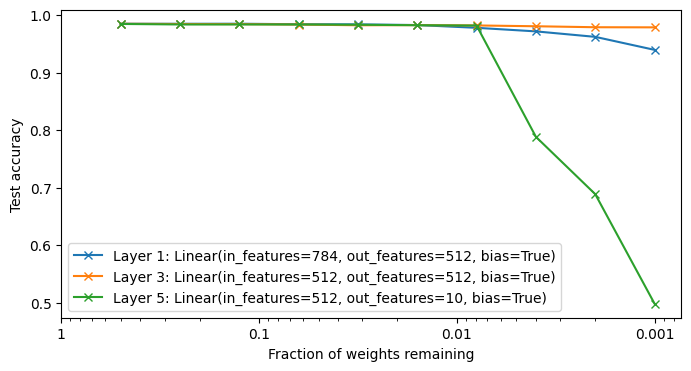

In [104]:
rates = np.logspace(-0.3,-3,10)
plt.figure(figsize=(8,4))
for i, layer_accs in enumerate(accs):
    # layer_accs.reverse()
    plt.plot(rates, layer_accs, 'x-', label=f'Layer {i*2+1}: {model.model[i*2]}')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.ylabel('Test accuracy')
plt.xlabel('Fraction of weights remaining')
plt.xticks([1, 0.1,0.01,0.001], labels=[1, 0.1,0.01,0.001])
plt.legend()
plt.show()